<a href="https://colab.research.google.com/github/sohamtalukdar/Enron-Email-Analysis/blob/main/Vlabs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir "/content/drive/MyDrive/maildir/"
!tar -xzvf "/content/drive/MyDrive/enron_with_categories.tar.gz" -C "/content/drive/MyDrive/maildir/"

mkdir: cannot create directory ‘/content/drive/MyDrive/maildir/’: File exists
enron_with_categories/
enron_with_categories/1/
enron_with_categories/1/114715.txt
enron_with_categories/1/114715.cats
enron_with_categories/1/229405.txt
enron_with_categories/1/229405.cats
enron_with_categories/1/232795.txt
enron_with_categories/1/232795.cats
enron_with_categories/1/62815.txt
enron_with_categories/1/62815.cats
enron_with_categories/1/118871.txt
enron_with_categories/1/118871.cats
enron_with_categories/1/106588.txt
enron_with_categories/1/106588.cats
enron_with_categories/1/122973.txt
enron_with_categories/1/122973.cats
enron_with_categories/1/106590.txt
enron_with_categories/1/106590.cats
enron_with_categories/1/139359.txt
enron_with_categories/1/139359.cats
enron_with_categories/1/136551.txt
enron_with_categories/1/136551.cats
enron_with_categories/1/98429.txt
enron_with_categories/1/98429.cats
enron_with_categories/1/221314.txt
enron_with_categories/1/221314.cats
enron_with_categories/1/54

In [ ]:
import os
import csv
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk.stem as stemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.stem import SnowballStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import gensim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


In [4]:
#Map folder names to label values
labels = {
    "1": "Company Business, Strategy, etc.",
    "2": "Purely Personal",
    "3": "Personal but in professional context",
    "4": "Logistic Arrangements",
    "5": "Status arrangements",
    "6": "Document editing/checking",
    "7": "Empty message (due to missing attachment)",
    "8": "Empty message"
}

root_directory = '/content/drive/MyDrive/maildir/enron_with_categories/'
rows = []

for folder_name in os.listdir(root_directory):
    folder_path = os.path.join(root_directory, folder_name)
    if os.path.isdir(folder_path):
        label = labels[folder_name]
        for filename in os.listdir(folder_path):
            if filename.endswith(".txt"):
                with open(os.path.join(folder_path, filename), 'r') as f:
                    data = f.read()
                    message_body = data.split("\n\n")[-1]
                    number = int(filename.split(".")[0])
                    rows.append({"#": number,"Label": label,"Message": message_body})

df = pd.DataFrame(rows)


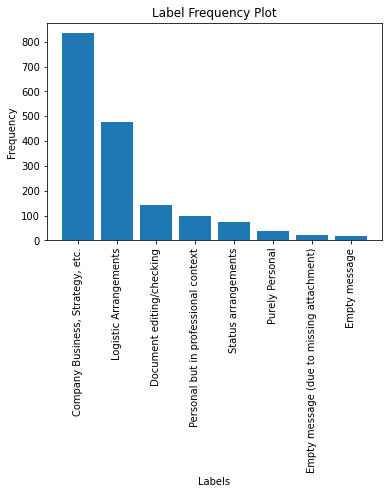

In [6]:
import matplotlib.pyplot as plt

label_counts = df['Label'].value_counts()
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Label Frequency Plot')
plt.xticks(rotation=90)
plt.show()


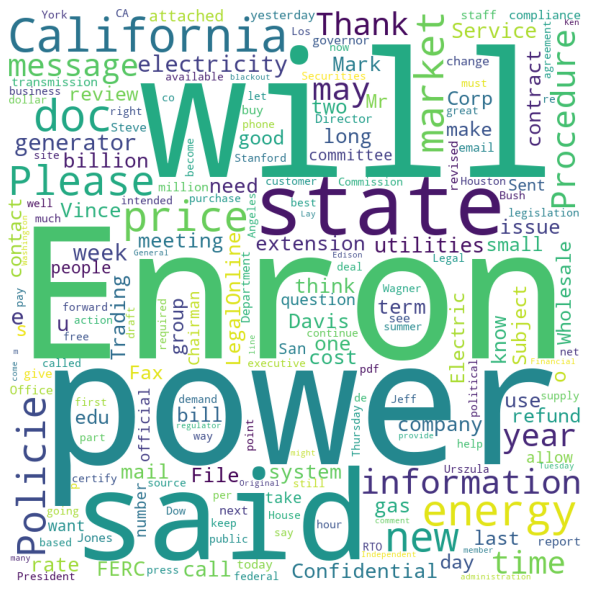

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = " ".join(df['Message'].values.tolist())
wordcloud = WordCloud(width=800, height=800, min_font_size=10, background_color='white', 
                      stopwords=None, collocations=False).generate(all_text)

plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


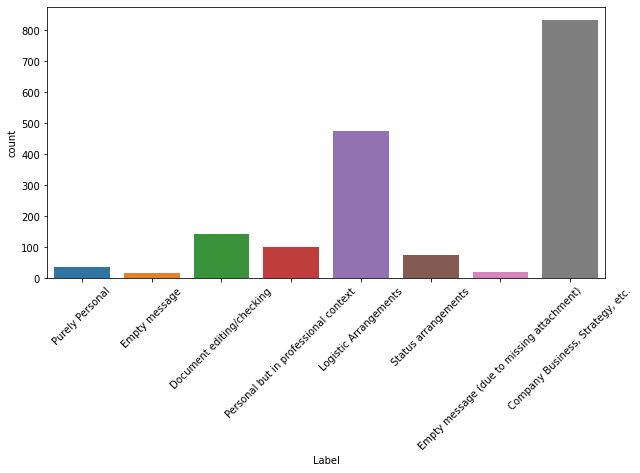

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.countplot(x='Label', data=df)
plt.xticks(rotation=45)
plt.show()


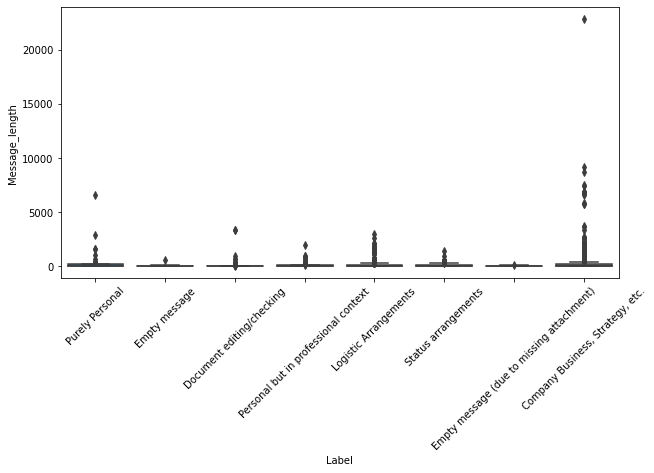

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

df['Message_length'] = df['Message'].apply(lambda x: len(x))

plt.figure(figsize=(10,5))
sns.boxplot(x='Label', y='Message_length', data=df)
plt.xticks(rotation=45)
plt.show()


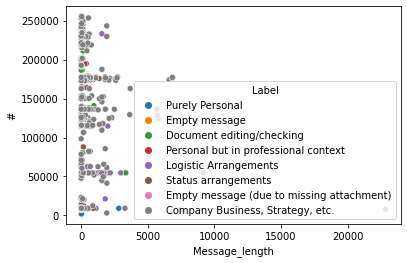

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x='Message_length', y='#', hue='Label', data=df)
plt.show()


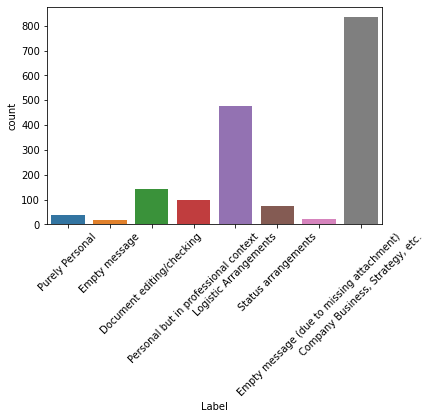

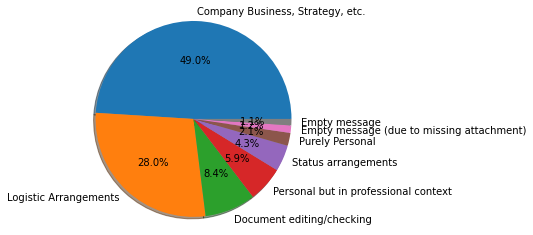

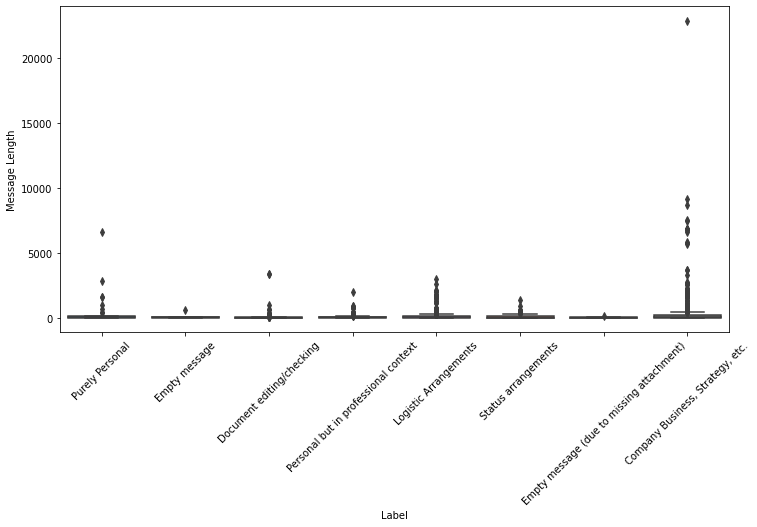

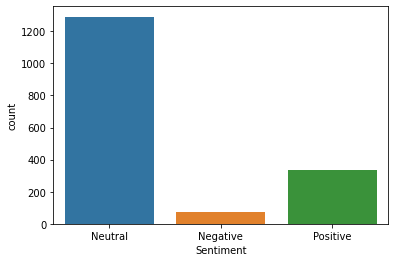

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np

# Bar Plot for email count in each category
sns.countplot(x='Label', data=df)
plt.xticks(rotation=45)
plt.show()

# Word Cloud for the content of the emails in each category
def plot_wordcloud(label):
    wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(" ".join(df[df['Label'] == label]['Message']))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

# Pie Chart for email count in each category
labels = df['Label'].value_counts().index
sizes = df['Label'].value_counts().values

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax.axis('equal')
plt.show()

# Box Plot for message length in each category
df['Message Length'] = df['Message'].apply(lambda x : len(x))
plt.figure(figsize=(12,6))
sns.boxplot(x='Label', y='Message Length', data=df)
plt.xticks(rotation=45)
plt.show()

# Stacked Bar Plot for the most frequent words in each category
def plot_stacked_bar(label):
    words = df[df['Label'] == label]['Message'].str.split(expand=True).stack().value_counts()
    words[:10].plot(kind='bar', stacked=True)
    plt.xticks(rotation=45)
    plt.show()

# Sentiment Analysis
from textblob import TextBlob

df['Sentiment'] = df['Message'].apply(lambda x : TextBlob(x).sentiment[0])
df['Sentiment'] = df['Sentiment'].apply(lambda x : 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
sns.countplot(x='Sentiment', data=df)
plt.show()


In [5]:
df

,#,Label,Message
0,192771,Purely Personal,
1,54659,Purely Personal,\nThe Hormone Hostage knows that there are da...
2,176571,Purely Personal,
3,176572,Purely Personal,
4,176609,Purely Personal,
...,...,...,...
1697,136408,"Company Business, Strategy, etc.","Finally, Andy Black of Chairman Barton's staff..."
1698,136409,"Company Business, Strategy, etc.",SEC. 410. ELECTRIC RELIABILITY STANDARDS.\nP...
1699,136411,"Company Business, Strategy, etc.",Key task when House staff return to work on Tu...
1700,136413,"Company Business, Strategy, etc.",Yesterday I spent about 45 minutes with the th...


In [16]:
# Clean the email message
df['Message'] = df['Message'].apply(lambda x: re.sub(r'[^\w\s]|\d', '', x).lower())
df['Message'] = df['Message'].apply(lambda x: re.sub(r'\S+@\S+', '', x))
df['Message'] = df['Message'].apply(lambda x: re.sub(r'http\S+', '', x))
df['Message'] = df['Message'].apply(lambda x: " ".join([word for word in word_tokenize(x) if word.isalpha() and word not in set(stopwords.words("english"))]))
df['Message'] = df['Message'].apply(lambda x: " ".join([SnowballStemmer("english").stem(word) for word in x.split()]))

# Drop rows with "Empty message (due to missing attachment)" or "Empty message" labels
df = df[df['Label'] != 'Empty message (due to missing attachment)']
df = df[df['Label'] != 'Empty message']

# Drop rows with empty Message column
df = df.dropna(subset=['Message'])
df = df[df['Message'] != '']

# Remove duplicates
df.drop_duplicates(inplace=True)

In [17]:
df

,#,Label,Message,Message_length,Message Length,Sentiment
1,54659,Purely Personal,hormon hostag know day month man open mouth ta...,999,999,Negative
6,09176,Purely Personal,call nbcs cant see tv cheap rate ploy work the...,2823,2823,Positive
7,174265,Purely Personal,test note capabl enron home comput,55,55,Neutral
8,54544,Purely Personal,kevin moor,34,34,Neutral
9,54545,Purely Personal,spoke friend ibm san jose offic ibm fellow adv...,666,666,Positive
...,...,...,...,...,...,...
1695,128209,"Company Business, Strategy, etc.",best jeff financi california chang stanc refun...,5756,5756,Positive
1697,136408,"Company Business, Strategy, etc.",final andi black chairman barton staff advis r...,550,550,Positive
1698,136409,"Company Business, Strategy, etc.",sec electr reliabl standard part ii feder powe...,1817,1817,Positive
1699,136411,"Company Business, Strategy, etc.",key task hous staff return work tuesday find r...,229,229,Neutral


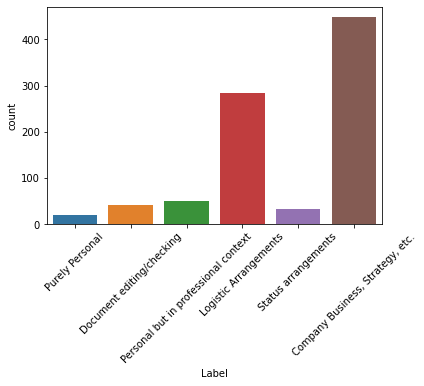

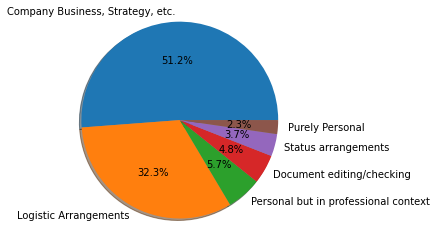

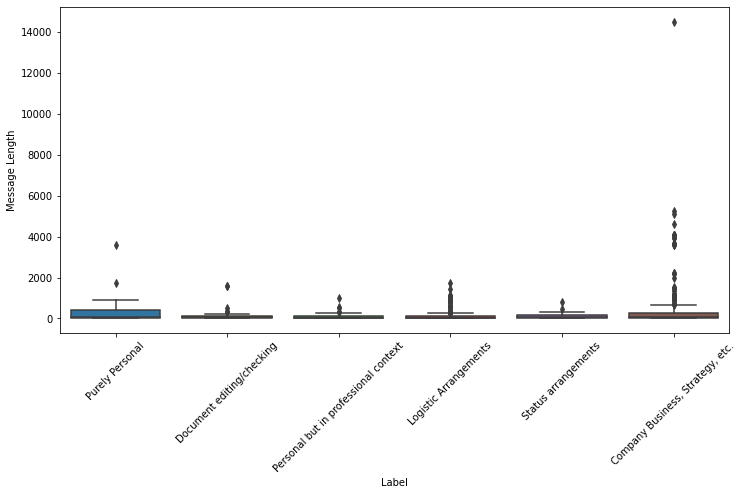

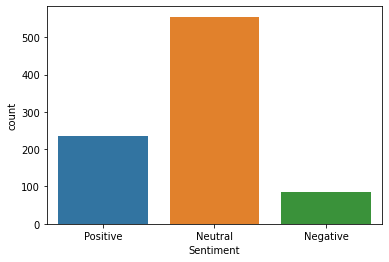

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np

# Bar Plot for email count in each category
sns.countplot(x='Label', data=df)
plt.xticks(rotation=45)
plt.show()

# Word Cloud for the content of the emails in each category
def plot_wordcloud(label):
    wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(" ".join(df[df['Label'] == label]['Message']))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

# Pie Chart for email count in each category
labels = df['Label'].value_counts().index
sizes = df['Label'].value_counts().values

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax.axis('equal')
plt.show()

# Box Plot for message length in each category
df['Message Length'] = df['Message'].apply(lambda x : len(x))
plt.figure(figsize=(12,6))
sns.boxplot(x='Label', y='Message Length', data=df)
plt.xticks(rotation=45)
plt.show()

# Stacked Bar Plot for the most frequent words in each category
def plot_stacked_bar(label):
    words = df[df['Label'] == label]['Message'].str.split(expand=True).stack().value_counts()
    words[:10].plot(kind='bar', stacked=True)
    plt.xticks(rotation=45)
    plt.show()

# Sentiment Analysis
from textblob import TextBlob

df['Sentiment'] = df['Message'].apply(lambda x : TextBlob(x).sentiment[0])
df['Sentiment'] = df['Sentiment'].apply(lambda x : 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
sns.countplot(x='Sentiment', data=df)
plt.show()


In [ ]:
# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(df['Message'])

# scaler = StandardScaler(with_mean=False)
# X = scaler.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(X, df['Label'], test_size=0.2, random_state=0)


In [ ]:
# ### Naive Bayes ###

# model = MultinomialNB()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))


In [ ]:
# ### Random Forest ###

# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# ### Support Vector Machine ###

# model = SVC(kernel='linear', C=1, random_state=42)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))



In [ ]:
# #### Word2Vec #####


# # Get the messages as a list of lists of words
# messages = df['Message'].apply(lambda x: x.split()).tolist()
# # Train the CBOW word2vec model
# model = Word2Vec(messages, sg=1, window=5, min_count=1, negative=10, seed=0)

# # Split the data into train and test sets
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

# # Get the train and test labels and messages
# train_labels = train_df['Label'].tolist()
# train_messages = train_df['Message'].apply(lambda x: x.split()).tolist()
# test_labels = test_df['Label'].tolist()
# test_messages = test_df['Message'].apply(lambda x: x.split()).tolist()

# # Convert the messages to average word vectors
# train_vectors = np.zeros((len(train_messages), 100))
# for i, message in enumerate(train_messages):
#     vectors = np.zeros((100,))
#     for word in message:
#         if word in model.wv:
#             vectors += model.wv[word]
#     vectors = vectors / len(message)
#     train_vectors[i] = vectors

# test_vectors = np.zeros((len(test_messages), 100))
# for i, message in enumerate(test_messages):
#     vectors = np.zeros((100,))
#     for word in message:
#         if word in model.wv:
#             vectors += model.wv[word]
#     vectors = vectors / len(message)
#     test_vectors[i] = vectors

# # Train a classifier on the train data
# classifier = SVC(kernel='linear', C=1)
# classifier.fit(train_vectors, train_labels)

# # Predict the labels for the test data
# predictions = classifier.predict(test_vectors)

# # Evaluate the model using metrics such as accuracy, precision, recall, and F1-score
# accuracy = accuracy_score(test_labels, predictions)
# precision = precision_score(test_labels, predictions, average='weighted', zero_division=0)
# recall = recall_score(test_labels, predictions, average='weighted')
# #f1_score = f1_score(test_labels, predictions, average='weighted')

# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# #print("F1-Score:", f1_score)


In [ ]:
# ! pip install transformers
# from transformers import BertTokenizer
# import pandas as pd
# import numpy as np
# import torch
# import torch.nn as nn
# import transformers

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# df['Message'] = df['Message'].apply(lambda x: tokenizer.encode(str(x), add_special_tokens=True, max_length=512, padding='max_length', truncation=True))

# max_len = df['Message'].apply(lambda x: len(x)).max()
# df['Message'] = df['Message'].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant'))
# df['Label'] = df['Label'].map({label: i for i, label in enumerate(labels.values())})

# from sklearn.model_selection import train_test_split
# train_data, validation_data, train_labels, validation_labels = train_test_split(df['Message'].tolist(), df['Label'].tolist(), test_size=0.2, random_state=42)

# train_data = torch.tensor(train_data)
# validation_data = torch.tensor(validation_data)
# train_labels = torch.tensor(train_labels)
# validation_labels = torch.tensor(validation_labels)
# model = transformers.BertModel.from_pretrained('bert-base-uncased')
# classifier = nn.Linear(model.config.hidden_size, len(labels))
# model.classifier = classifier
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
# epochs = 10
# for epoch in range(1, epochs + 1):
#     model.train()
#     running_loss = 0
#     for i, data in enumerate(zip(train_data, train_labels)):
#         optimizer.zero_grad()
#         inputs, label = data
#         outputs = model(inputs.unsqueeze(0))[0]
#         loss = criterion(outputs.view(-1, len(labels)), label.unsqueeze(0).long())
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#     if epoch % 5 == 0:
#         print('Epoch: {}/{}'.format(epoch, epochs), 'Loss: {:.4f}'.format(running_loss / len(train_data)))

In [ ]:
# df['Message'] = df['Message'].apply(lambda x: x.split())

# word_index = {}
# index = 0
# for message in df['Message']:
#     for word in message:
#         if word not in word_index:
#             word_index[word] = index
#             index += 1


# co_occurrence_matrix = np.zeros((len(word_index), len(word_index)))
# for message in df['Message']:
#     for i in range(len(message)):
#         for j in range(i + 1, len(message)):
#             co_occurrence_matrix[word_index[message[i]]][word_index[message[j]]] += 1
#             co_occurrence_matrix[word_index[message[j]]][word_index[message[i]]] += 1


# embedding_dim = 100
# X = np.zeros((len(word_index), embedding_dim))
# epochs = 30
# alpha = 0.75
# x_max = 100

# for epoch in range(epochs):
#     for i in range(len(word_index)):
#         for j in range(i + 1, len(word_index)):
#             if co_occurrence_matrix[i][j] == 0:
#                 continue
#             weight = (co_occurrence_matrix[i][j] / x_max) ** alpha
#             x = X[i]
#             y = X[j]
#             d = x - y
#             cost = weight * d
#             X[i] = x + cost * 0.05
#             X[j] = y - cost * 0.05



# import numpy as np
# from tqdm import tqdm

# def get_cooccurrence_matrix(corpus, vocab_size, window_size=10):
#     corpus = [word for message in corpus for word in message.split()]
#     word2idx = {word: i for i, word in enumerate(set(corpus))}
#     idx2word = {i: word for i, word in enumerate(set(corpus))}
    
#     cooccurrence_matrix = np.zeros((vocab_size, vocab_size))
    
#     for i, word in tqdm(enumerate(corpus), total=len(corpus)):
#         word_idx = word2idx[word]
#         for j in range(max(0, i - window_size), min(len(corpus), i + window_size + 1)):
#             if i != j:
#                 context_word = corpus[j]
#                 context_word_idx = word2idx[context_word]
#                 cooccurrence_matrix[word_idx][context_word_idx] += 1
                
#     return cooccurrence_matrix, word2idx, idx2word

# def get_embeddings(cooccurrence_matrix, word2idx, idx2word, embedding_size=100):
#     vocab_size = cooccurrence_matrix.shape[0]
#     X = np.random.randn(vocab_size, embedding_size)
#     Y = np.random.randn(vocab_size, embedding_size)
    
#     epochs = 100
#     learning_rate = 0.01
    
#     for epoch in range(epochs):
#         for i in tqdm(range(vocab_size), total=vocab_size):
#             word_embedding = X[i, :]
#             for j in range(vocab_size):
#                 context_word_embedding = Y[j, :]
#                 cooccurrence = cooccurrence_matrix[i][j]
                
#                 if cooccurrence != 0:
#                     weight = (cooccurrence / np.sum(cooccurrence_matrix[i, :]))**0.75
#                     diff = word_embedding - context_word_embedding
#                     X[i, :] -= learning_rate * weight * diff
#                     Y[j, :] += learning_rate * weight * diff
                    
#     embeddings = {idx2word[i]: X[i, :] for i in range(vocab_size)}
    
#     return embeddings

# corpus = df['Message'].values.tolist()
# cooccurrence_matrix, word2idx, idx2word = get_cooccurrence_matrix(corpus, 5000)
# embeddings = get_embeddings(cooccurrence_matrix, word2idx, idx2word)